In [27]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9649608931896578635
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6267797504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11164093609194203266
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [28]:
import numpy as np
import os
import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [29]:
label_data1 = pd.read_csv('dataset/train_label1.csv')
# label_data2 = pd.read_csv('dataset/label2.csv', encoding='euc-kr')

In [30]:
name = ['0','1','2','3','4','5','6','7','8','9','10','가렵다','개','공원','금요일','내년','내일','냄새나다',
        '누나','동생','목요일','물','아래','바다','배고프다','병원','불','산','삼키다','선생님','수요일','아빠',
        '아파트','앞','어제','어지러움','언니','엄마','오늘','오른쪽','오빠','올해','왼쪽','월요일','위에',
        '음식물','일요일','자동차','작년','집','친구','택시','토요일','학교','형','화요일','화장실'
]


In [48]:
data1 = np.load('dataset/train_data1_win10_ver03')
data2 = np.load('dataset/train_data2_win10_ver03')

In [49]:
lab1 = label_data1.values
# lab2 = label_data2.values

In [50]:
for i in range(len(data1)):
    num = data1[i,0,-1]
    label_num = lab1[int(num)][0]
    num = name.index(label_num)
    data1[i,:,-1] = num

In [7]:
for i in range(len(data2)):
    num = data2[i,0,-1]
    label_num = lab2[int(num)][0]
    num = name.index(label_num)
    data2[i,:,-1] = num

In [51]:
action = ['가다','감사합니다','괜찮습니다','나','남자','내리다','당신','돕다','맞다',
'모르다','미안합니다','반드시','부탁합니다','빨리','수고','수화','슬프다','싫다',
'아니다','안녕하세요','알다','없다','여자','오다','있다','잘','좋다','주다','타다']

actions = name.copy() + action
# actions = ['a','b']

data = np.concatenate([
    data1, data2
], axis=0)

data.shape

(36209, 20, 94)

In [52]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(36209, 20, 93)
(36209,)


In [53]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(36209, 86)

In [54]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(32588, 20, 93) (32588, 86)
(3621, 20, 93) (3621, 86)


In [55]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

keras.backend.clear_session()

model = Sequential()

model.add(LSTM(512, input_shape=x_train.shape[1:3], recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))
# model = Sequential([
#     LSTM(128, activation='relu', input_shape=x_train.shape[1:3]),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(len(actions), activation='softmax')
# ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1241088   
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 86)                5590      
                                                                 
Total params: 1,279,510
Trainable params: 1,279,510
Non-trainable params: 0
_________________________________________________________________


In [56]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1, min_delta=0)
mc = ModelCheckpoint('models/model_3.h5', monitor='val_loss', verbose=1, save_best_only=True)

with tf.device("/device:GPU:0"):
    history = model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        batch_size=64,
        epochs=500,
        verbose=1,
        callbacks=[
            es,mc
        ]
    )

Epoch 1/500
408/408 [==============================] - ETA: 0s - loss: 1.3779 - accuracy: 0.6567
Epoch 00001: val_loss improved from inf to 0.64300, saving model to models\model_3.h5
408/408 [==============================] - 69s 167ms/step - loss: 1.3779 - accuracy: 0.6567 - val_loss: 0.6430 - val_accuracy: 0.8093
Epoch 2/500
408/408 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.8612
Epoch 00002: val_loss improved from 0.64300 to 0.41897, saving model to models\model_3.h5
408/408 [==============================] - 69s 170ms/step - loss: 0.4852 - accuracy: 0.8612 - val_loss: 0.4190 - val_accuracy: 0.8713
Epoch 3/500
408/408 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.8990
Epoch 00003: val_loss improved from 0.41897 to 0.28683, saving model to models\model_3.h5
408/408 [==============================] - 68s 167ms/step - loss: 0.3275 - accuracy: 0.8990 - val_loss: 0.2868 - val_accuracy: 0.9090
Epoch 4/500
408/408 [====================

KeyError: 'acc'

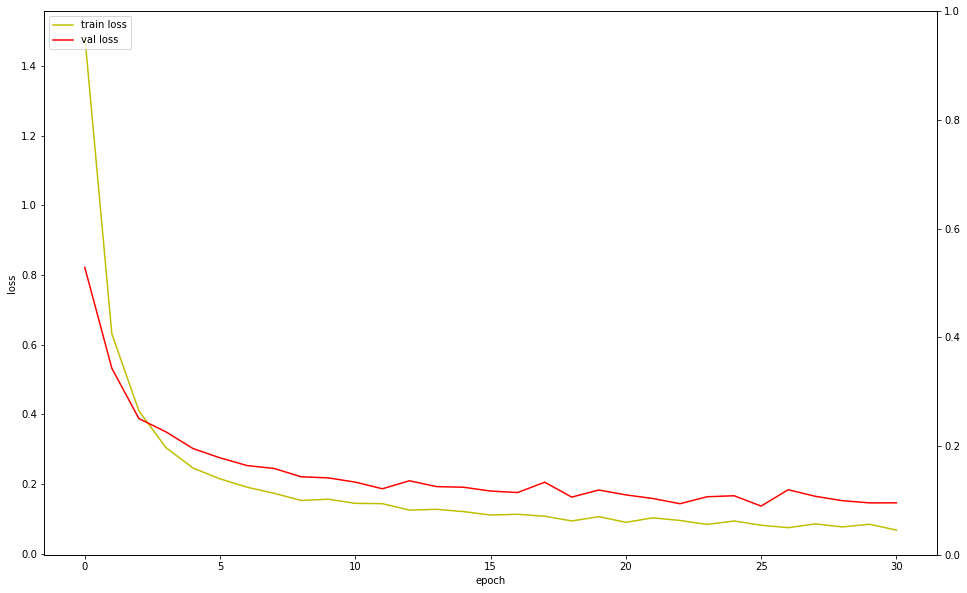

In [45]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [47]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model_xyz_angle.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[4914,    3],
        [   1,   30]],

       [[4914,    1],
        [   3,   30]],

       [[4896,    7],
        [   0,   45]],

       [[4883,    2],
        [  10,   53]],

       [[4908,    3],
        [   0,   37]],

       [[4882,    0],
        [  11,   55]],

       [[4882,    5],
        [   5,   56]],

       [[4874,    3],
        [   3,   68]],

       [[4893,    0],
        [   3,   52]],

       [[4899,    6],
        [   1,   42]],

       [[4896,    0],
        [   4,   48]],

       [[4889,    0],
        [   1,   58]],

       [[4889,    2],
        [   2,   55]],

       [[4875,    7],
        [   4,   62]],

       [[4900,    1],
        [   3,   44]],

       [[4908,    2],
        [   1,   37]],

       [[4906,    1],
        [   6,   35]],

       [[4894,    2],
        [   0,   52]],

       [[4906,    3],
        [  24,   15]],

       [[4917,    0],
        [   1,   30]],

       [[4893,    0],
        [   4,   51]],

       [[4886,    4],
        [  1